Using revised classified datasets, generate acceptance function using Legendre polynomials. 

1. Generate Legendre coefficients 
2. Plot results for different projections 
3. Quantify goodness of fit (chi-2, KS...) 
4. Export for fit group 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import pickle
from scipy.stats.distributions import chi2
from scipy.stats import kstest

In [3]:
from data_loader import *
from find_coeff_numpy import legendre_eval, legendre_eval_project_1D, legendre_eval_project_2D, find_coeff

## import data

In [4]:
data_path = '../classification/final_data_processed/'
acceptance_dataset_fp = data_path + 'acceptance_classified.pkl'
acceptance = pd.read_pickle(acceptance_dataset_fp)
acceptance.shape

(379643, 7)

In [5]:
acceptance['phi'].describe()

count    379643.000000
mean         -0.004430
std           1.820914
min          -3.141569
25%          -1.577794
50%          -0.010461
75%           1.572256
max           3.141592
Name: phi, dtype: float64

In [6]:
# convention is: costhetal, costhetak, phi
angle_names = ['costhetal', 'costhetak', 'phi']
acceptance_angles = acceptance[angle_names].to_numpy()
acceptance_angles.shape

(379643, 3)

## helper functions for visualisation

In [7]:
def norm_mean(a):
    return a / np.mean(a)

In [8]:
N = 50
bin_edges_cos = np.linspace(-1, 1, N)
bin_centers_cos = (bin_edges_cos[:-1] + bin_edges_cos[1:]) / 2
bin_edges_phi = bin_edges_cos * np.pi
bin_centers_phi = bin_centers_cos * np.pi

In [9]:
acc_ctl_hist, _ = np.histogram(acceptance_angles[:,0], bins=bin_edges_cos)
acc_ctk_hist, _ = np.histogram(acceptance_angles[:,1], bins=bin_edges_cos)
acc_phi_hist, _ = np.histogram(acceptance_angles[:,2], bins=bin_edges_phi)

bin_edges = [bin_edges_cos, bin_edges_cos, bin_edges_phi]
bin_centers = [bin_centers_cos, bin_centers_cos, bin_centers_phi]
acc_hists = [acc_ctl_hist, acc_ctk_hist, acc_phi_hist]

helper_collection = [angle_names, bin_edges, bin_centers, acc_hists]

In [10]:
q2_ranges, len(q2_ranges)

([(0.1, 0.98),
  (1.1, 2.5),
  (2.5, 4.0),
  (4.0, 6.0),
  (6.0, 8.0),
  (15.0, 17.0),
  (17.0, 19.0),
  (11.0, 12.5),
  (1.0, 6.0),
  (15.0, 17.9)],
 10)

## Legendre parameterisation overall (not final, as not binned by q2)

In [11]:
order = [4, 4, 6]
C = find_coeff(acceptance_angles, order=order)

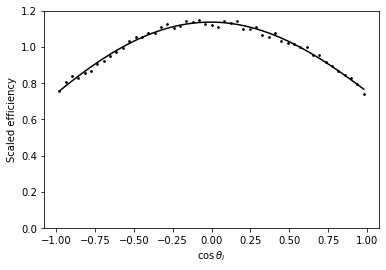

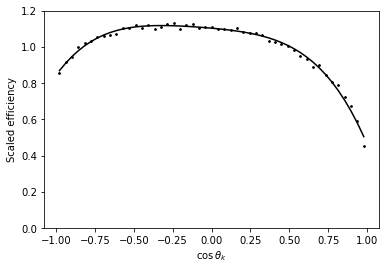

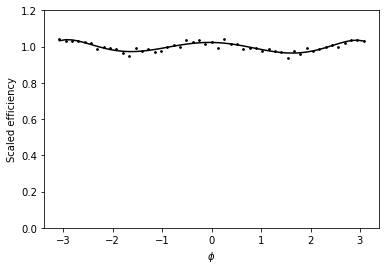

In [12]:
for i, (name, be, bc, ah) in enumerate(zip(*helper_collection)):
    hist_L = legendre_eval_project_1D(C, bc, i)
    
    plt.scatter(bc, norm_mean(ah), c='black', s=3)
    plt.plot(bc, norm_mean(hist_L), c='black')
    plt.ylim(0, 1.2)
    plt.xlabel([r'$\cos\theta_l$', r'$\cos\theta_k$', r'$\phi$'][i])
    plt.ylabel('Scaled efficiency')
    plt.show()

## plot projections for each q2 bin

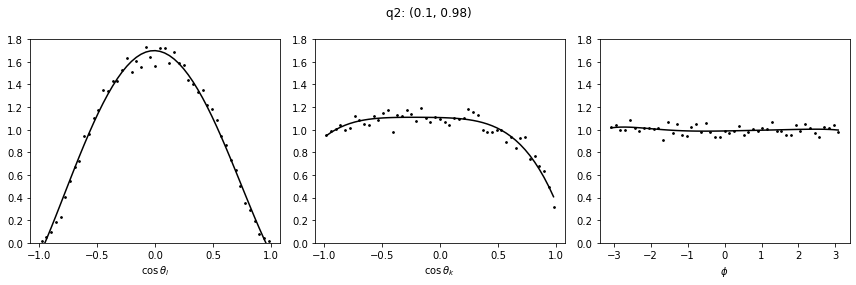

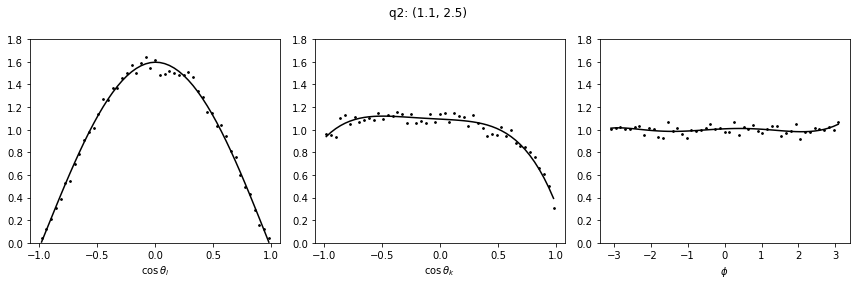

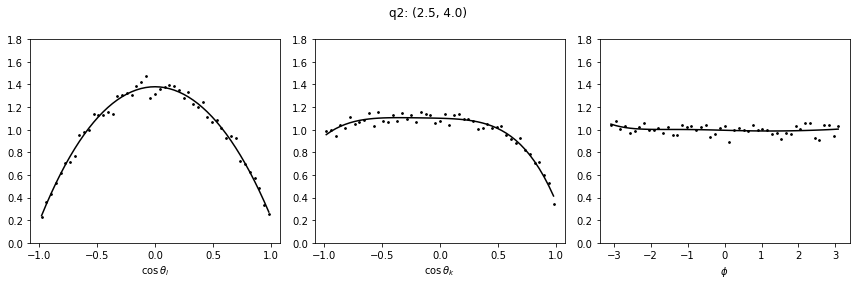

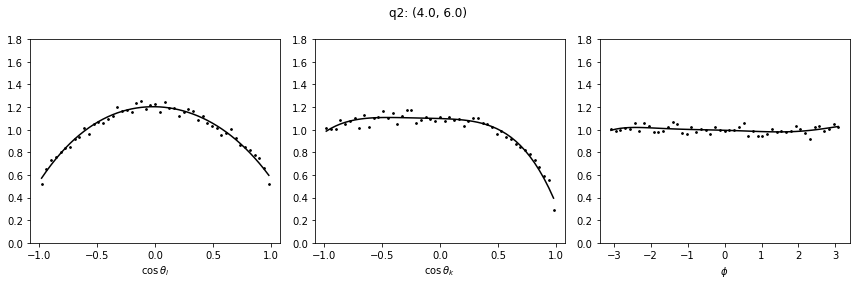

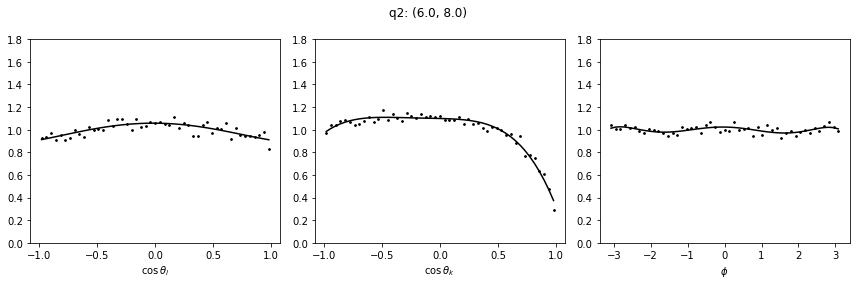

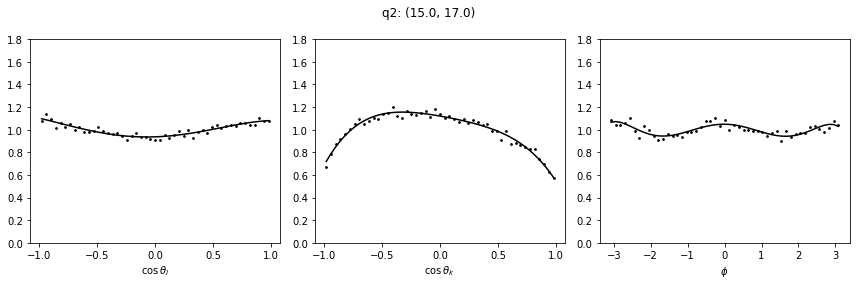

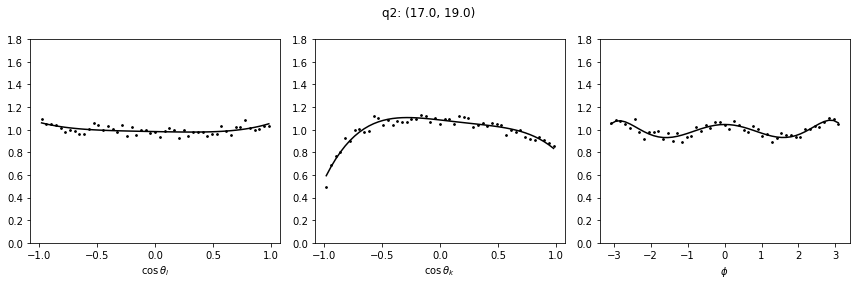

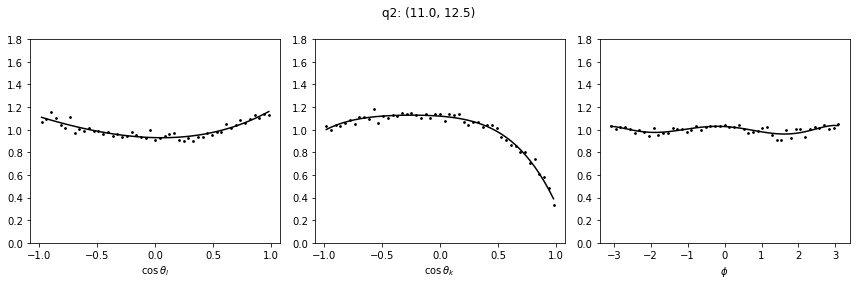

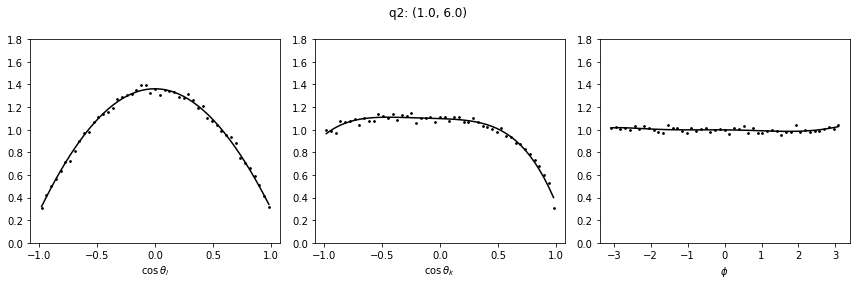

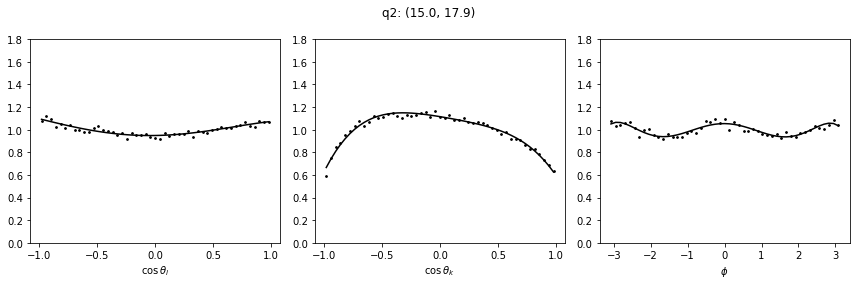

In [13]:
order = [4, 4, 6]
for i in range(len(q2_ranges)):
    acc_binned = extract_bin_number(acceptance, i)
    acc_angles = acc_binned[angle_names].to_numpy()
    C = find_coeff(acc_angles, order=order)
    
    plt.figure(figsize=(12, 4))
    for j in range(3):
        hist_acc, _ = np.histogram(acc_angles[:,j], bins=bin_edges[j])
        hist_L = legendre_eval_project_1D(C, bin_centers[j], j)
        
        plt.subplot(1, 3, j+1)
        plt.scatter(bin_centers[j], norm_mean(hist_acc), c='black', s=3)
        plt.plot(bin_centers[j], norm_mean(hist_L), c='black')
        plt.ylim(0, 1.8)
        plt.xlabel([r'$\cos\theta_l$', r'$\cos\theta_k$', r'$\phi$'][j])
        
    plt.suptitle(f'q2: {q2_ranges[i]}')
    plt.tight_layout()
    plt.show()

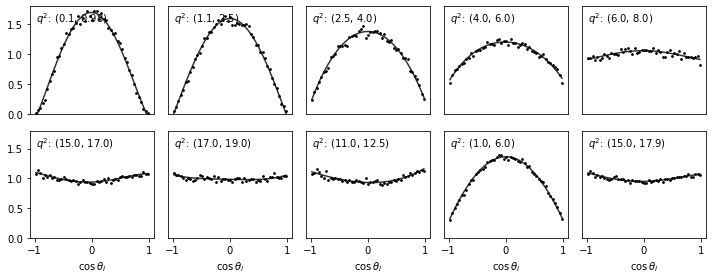

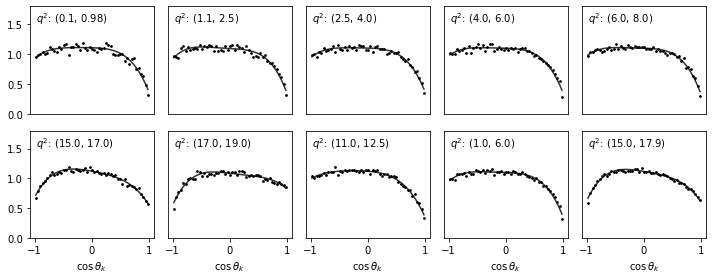

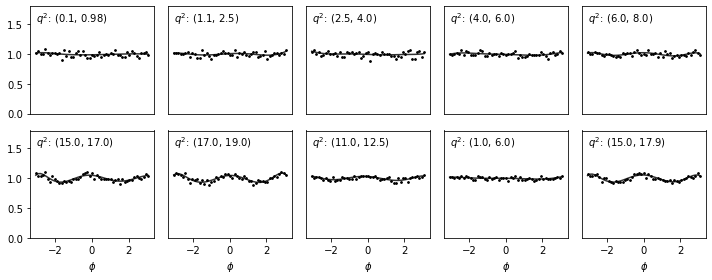

In [14]:
order = [4, 4, 7]

for j in range(3):
    
    plt.figure(figsize=(10, 4)) 
    for i in range(len(q2_ranges)):
        acc_binned = extract_bin_number(acceptance, i)
        acc_angles = acc_binned[angle_names].to_numpy()
        C = find_coeff(acc_angles, order=order)
    
        hist_acc, _ = np.histogram(acc_angles[:,j], bins=bin_edges[j])
        hist_L = legendre_eval_project_1D(C, bin_centers[j], j)
        
        plt.subplot(2, 5, i+1)
        plt.scatter(bin_centers[j], norm_mean(hist_acc), c='black', s=3)
        plt.plot(bin_centers[j], norm_mean(hist_L), c='black', alpha=0.8)
        plt.annotate(rf'$q^2$: {q2_ranges[i]}', xy=(0.05, 0.85), xycoords='axes fraction')
        plt.ylim(0, 1.8)
        
#         K, p_val = kstest(norm_mean(hist_acc), norm_mean(hist_L))
#         plt.annotate(f'p-value: {p_val:.3f}', xy=(0.05, 0.05), xycoords='axes fraction')
        
        if i < 5:
            plt.xticks([])
        
        if i != 0 and i != 5:
            plt.yticks([])
        
        if i >= 5:
            plt.xlabel([r'$\cos\theta_l$', r'$\cos\theta_k$', r'$\phi$'][j])
        
#     plt.suptitle([r'$\cos\theta_l$', r'$\cos\theta_k$', r'$\phi$'][j])
    plt.tight_layout()
#     plt.savefig(f'./output/acceptance_projections/{angle_names[j]}.pdf')
    plt.show()

## calculate chi-2 and KS

In [15]:
# adapted from Andres' code
def chi_err(data, fit, order):
    chi = np.sum((data - fit)**2 / fit)
    dof = data.shape[0] - order - 1
    p_value = chi2.sf(chi, dof)
    return p_value, chi / dof, chi

In [16]:
order = [4, 4, 6]

for j in range(3):
    for i in range(len(q2_ranges)):
        acc_binned = extract_bin_number(acceptance, i)
        acc_angles = acc_binned[angle_names].to_numpy()
        C = find_coeff(acc_angles, order=order)
    
        hist_acc, _ = np.histogram(acc_angles[:,j], bins=bin_edges[j])
        hist_L = legendre_eval_project_1D(C, bin_centers_cos, j)
        
        p_val, chi2_reduced, chi = chi_err(norm_mean(hist_acc), norm_mean(hist_L), order=order[j])
        print(f'{angle_names[j]}, bin {i}: pval={p_val:.2f}, chi2-reduced={chi2_reduced:.5f}, chi={chi:.3f}')

costhetal, bin 0: pval=1.00, chi2-reduced=0.00031, chi=0.013
costhetal, bin 1: pval=1.00, chi2-reduced=0.01040, chi=0.457
costhetal, bin 2: pval=1.00, chi2-reduced=0.00195, chi=0.086
costhetal, bin 3: pval=1.00, chi2-reduced=0.00132, chi=0.058
costhetal, bin 4: pval=1.00, chi2-reduced=0.00170, chi=0.075
costhetal, bin 5: pval=1.00, chi2-reduced=0.00056, chi=0.025
costhetal, bin 6: pval=1.00, chi2-reduced=0.00103, chi=0.045
costhetal, bin 7: pval=1.00, chi2-reduced=0.00096, chi=0.042
costhetal, bin 8: pval=1.00, chi2-reduced=0.00067, chi=0.029
costhetal, bin 9: pval=1.00, chi2-reduced=0.00043, chi=0.019
costhetak, bin 0: pval=1.00, chi2-reduced=0.00326, chi=0.144
costhetak, bin 1: pval=1.00, chi2-reduced=0.00222, chi=0.098
costhetak, bin 2: pval=1.00, chi2-reduced=0.00157, chi=0.069
costhetak, bin 3: pval=1.00, chi2-reduced=0.00196, chi=0.086
costhetak, bin 4: pval=1.00, chi2-reduced=0.00149, chi=0.065
costhetak, bin 5: pval=1.00, chi2-reduced=0.00085, chi=0.038
costhetak, bin 6: pval=1

In [17]:
order = [4, 4, 6]

for j in range(3):
    for i in range(len(q2_ranges)):
        acc_binned = extract_bin_number(acceptance, i)
        acc_angles = acc_binned[angle_names].to_numpy()
        C = find_coeff(acc_angles, order=order)
    
        hist_acc, _ = np.histogram(acc_angles[:,j], bins=bin_edges[j])
        hist_L = legendre_eval_project_1D(C, bin_centers_cos, j)
        
        K, pval = kstest(norm_mean(hist_acc), norm_mean(hist_L))
        print(f'{angle_names[j]}, bin {i}: pval={pval:.3f}, KS={K:.4f}')

costhetal, bin 0: pval=1.000, KS=0.0612
costhetal, bin 1: pval=0.964, KS=0.1020
costhetal, bin 2: pval=0.964, KS=0.1020
costhetal, bin 3: pval=0.964, KS=0.1020
costhetal, bin 4: pval=0.170, KS=0.2245
costhetal, bin 5: pval=0.861, KS=0.1224
costhetal, bin 6: pval=0.020, KS=0.3061
costhetal, bin 7: pval=0.861, KS=0.1224
costhetal, bin 8: pval=1.000, KS=0.0612
costhetal, bin 9: pval=0.861, KS=0.1224
costhetak, bin 0: pval=0.063, KS=0.2653
costhetak, bin 1: pval=0.106, KS=0.2449
costhetak, bin 2: pval=0.106, KS=0.2449
costhetak, bin 3: pval=0.261, KS=0.2041
costhetak, bin 4: pval=0.170, KS=0.2245
costhetak, bin 5: pval=0.997, KS=0.0816
costhetak, bin 6: pval=0.964, KS=0.1020
costhetak, bin 7: pval=0.170, KS=0.2245
costhetak, bin 8: pval=0.261, KS=0.2041
costhetak, bin 9: pval=0.997, KS=0.0816
phi, bin 0: pval=0.000, KS=0.4898
phi, bin 1: pval=0.000, KS=0.4694
phi, bin 2: pval=0.000, KS=0.4694
phi, bin 3: pval=0.000, KS=0.4082
phi, bin 4: pval=0.001, KS=0.3878
phi, bin 5: pval=0.020, KS=0.3

## save Legendre parameterisations 

In [18]:
order = [4, 4, 6]
C_q2_bins = {}
for i in range(len(q2_ranges)):
    acc_binned = extract_bin_number(acceptance, i)
    acc_angles = acc_binned[angle_names].to_numpy()
    C = find_coeff(acc_angles, order=order)
    C_q2_bins[str(i)] = C

# np.savez('./output/acceptance_legendre_coeffs.npz', **C_q2_bins)